<a href="https://colab.research.google.com/github/gasparfj/NeuronalNetwork_ParkinsonSeverity_Prediction/blob/main/PAC2_GFJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PAC 1: ACTIVIDAD

Gaspar Fuster Jimenez

Machine Learning

In [8]:
# Importar librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1. Leer el fichero de datos parkinsons_updrs.data



Primero cargamos el fichero que el enunciado nos proporciona y lo leemos con pandas, indicando que la separación es por comas.

In [9]:
from google.colab import files
uploaded = files.upload() # Importar el fichero del enundiado

Saving parkinsons_updrs.data to parkinsons_updrs (1).data


In [10]:
data = pd.read_csv('parkinsons_updrs.data', sep=',') # Leer el archivo

## 2. Realizar una estadística descriptiva univariante de las variables que incluya tablas y gráficos.

In [11]:
data.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


## 3. Estandarizar mediante la transformación min-max las 16 variables que representan medidas biomédicas de la voz. Mostrar graficamente la transformación de las variables.

Antes de entrenar un algoritmo, es importante estandarizar los datos, ya que si una variable tiene una escala significativamente diferente al resto, esta puede influir de manera desproporcionada al modelo aunque esto no se corresponda con la realidad (@estandar).

Con el objetivo de mejorar el rendimiento del algoritmo, aplicaremos una estandarización de los datos min-max. Lo que transformará los datos a una escala de entre 0 (min) y 1 (max). Se utilizará la función MinMaxScaler() de la libreria sklearn.preprocessing.

In [12]:
voice_data = data.iloc[:, 6:] # Seleccionar datos para normalizar

scaler = MinMaxScaler() # Inicializar el escalador
voice_data_norm = scaler.fit_transform(voice_data) # Normalizar los datos

# Convertir a DataFrame
column_names = data.columns[6:]
voice_data_norm = pd.DataFrame(voice_data_norm, columns=column_names)

Ahora que tenemos estos datos estandarizados y almacenados en una variable, podemos visualizarlos con un mapa de calor con la función heatmap() de la libreria seaborn.

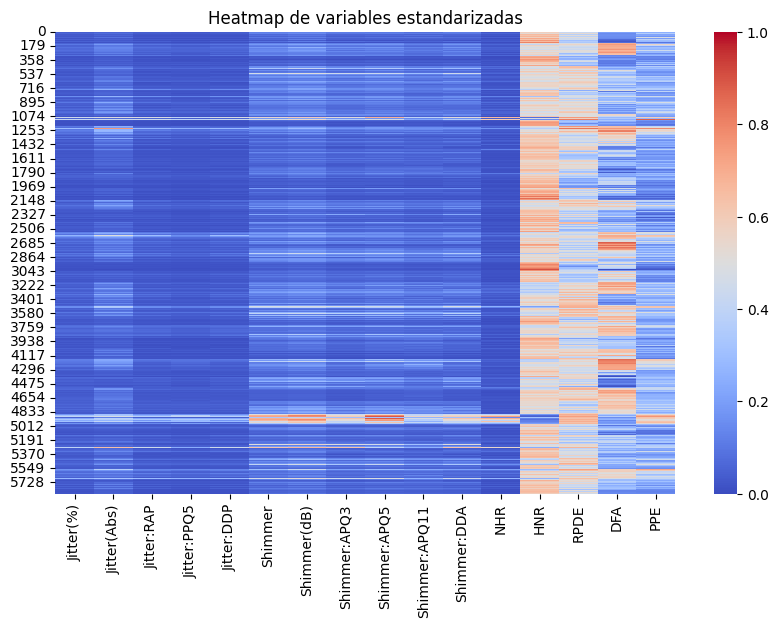

In [13]:
plt.figure(figsize=(10,6)) # Crear figura

sns.heatmap(voice_data_norm, cmap="coolwarm")  # Heatmap
plt.title("Heatmap de variables estandarizadas") # Titulo
plt.show()                                     # Dibujar figura

Observamos en esta figura el valor de cada variable en cada muestra, en una escala de color de azul (0) a rojo (1).

## 4. Crear la variable binaria de severidad del Parkinson. Mostrar en una tabla el numero de observaciones por severidad del Parkinson.

A continuación vamos a crear la variable que se quiere predecir (severidad). Esta, sera una variable binaria que se expresará como 1 si el valor de la variable "total_UPDRS" es mayor a 25 o 0 si es inferior.

Crearemos primero la lista de valores de esta variable con list comprehension y luego la convertiremos en data frame de pandas.

In [14]:
# Crear la variable severidad (1 si hay severidad, 0 si no)
severidad = [1 if i > 25 else 0 for i in data['total_UPDRS']]
severidad = pd.DataFrame(severidad, columns = ['severidad']) # Convertir a df

## 5. Separar los datos en training (67%) y test (33%).

En este punto, ya tenemos los datos con los que vamos a crear el moedelo. Tenemos, por una parte, las variables predictoras ya estandarizadas (voice_data_norm), y por otra parte, la variable a predecir (severidad).

Vamos a separarar estos datos aleatoriamente en entrenamiento y test.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    voice_data_norm, severidad, test_size=0.33, random_state=123)

## 6. Implementar una red neuronal profunda densa para la predicción de la severidad con dos capas ocultas de 10 y 10 nodos cada una. Adicionalmente, implementar una segunda red neuronal profunda densa con tres capas ocultas de 10, 20 y 10 nodos cada una.

### Definir los modelos

Crearemos dos redes neuronales (modelo y modelo2).

Ambos modelos serán de tipo "Sequential (una pila de capas con un valor de entrada y salida); las capas ocultas utilizarán la función de activación "relu", ya que es la que se utiliza de forma estandar en las capas ocultas (@activation, @Ringa_activation); en cambio, la función de activación de la capa de salida tendrá un nodo y la función de activación "sigmoid" que devuelve un valor entre 0 y 1, el cual representará la probabilidad de pertenecer a la clase 1 (severidad) o a la clase 0 (no severidad).

Los dos modelos difieren en el numero de capas ocultas y numero de nodos: el modelo tendrá 2 capas ocultas de 10 nodos cada uno y el modelo2 tentrá tres capas ocultas con 10, 20 y 10 nodos.

Estos modelos se crean con la libreria tensorflow.

In [16]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Dense(units=10, activation='relu', input_shape=[16]),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

modelo2 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=10, activation='relu', input_shape=[16]),
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compilar modelos

Aquí se optimizan los modelos. En los dos modelos se aplicará la metrica accuracy y se aplicará la función de perdida "Binary-CrossEntropy" (útil para variables binarias) (@coste).

In [17]:
modelo.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
)

modelo2.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
)

### Entrenar modelos

Finalmente entrenamos el modelo con nuestros datos de entrenamiento. Utilizaremos en los dos modelos 250 épocas y una batch size de 16 (estándar).

Para afinar el modelo se puede jugar con estos dos argumentos pero el objetivo de esta práctica no es afinar un mejor modelo sinó comparar dos modelos con diferentes capas ocultas.

In [18]:
print('Entrenando...')
historial = modelo.fit(
    X_train, y_train, epochs=250, batch_size=16,
    validation_data=(X_test, y_test), verbose=0
)
historial2 = modelo2.fit(
    X_train, y_train, epochs=250, batch_size=16,
    validation_data=(X_test, y_test), verbose=0
)
print('Modelos entrenados')

Entrenando...
Modelo entrenado


## Comparar el rendimiento de las dos redes neuronales en el conjunto test mediante sus curvas ROC y al menos otras 4 medidas de metricas de calidad. Crear tabla resumen.

Validar modelo

In [19]:
loss, accuracy = modelo.evaluate(X_test, y_test)
print(f"Pérdida modelo 1: {loss:.4f}")
print(f"Accuracy modelo 1: {accuracy:.4f}")

loss2, accuracy2 = modelo2.evaluate(X_test, y_test)
print(f"Pérdida modelo 2: {loss2:.4f}")
print(f"Accuracy modelo 2: {accuracy2:.4f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7136 - loss: 0.5455
Pérdida modelo 1: 0.5242
Accuracy modelo 1: 0.7287
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7550 - loss: 0.5280
Pérdida modelo 2: 0.5208
Accuracy modelo 2: 0.7473


Predicciones

In [20]:
y_pred = modelo.predict(X_test)
y_pred2 = modelo2.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


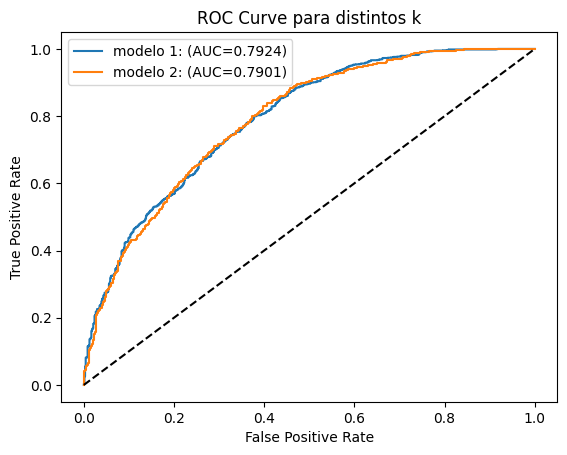

In [22]:
fpr, tpr, tresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr) # Calcular el area bajo la curva

fpr2, tpr2, tresholds2 = roc_curve(y_test, y_pred2)
roc_auc2 = auc(fpr2, tpr2) # Calcular el area bajo la curva

plt.plot(fpr, tpr, label=f"modelo 1: (AUC={roc_auc:.4f})")
plt.plot(fpr2, tpr2, label=f"modelo 2: (AUC={roc_auc2:.4f})")
plt.plot([0,1],[0,1],'k--')  # Linea diagonal
plt.xlabel("False Positive Rate") # Titulo eje x
plt.ylabel("True Positive Rate") # Titulo eje y
plt.title("ROC Curve para distintos k") # Titulo del grafico
plt.legend() # Incluir leyenda
plt.show() # Mostrar el grafico

Text(0.5, 1.0, 'Matriz de confusion - Modelo 2')

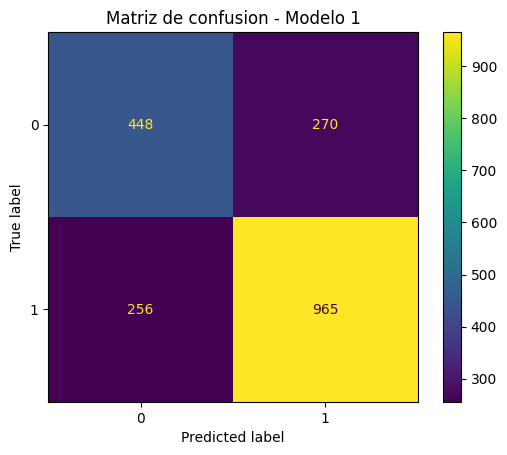

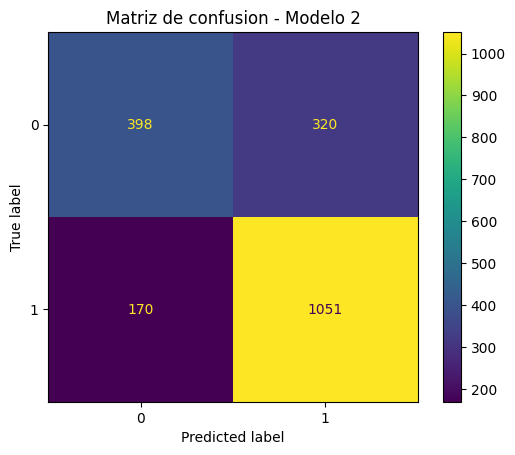

In [23]:
# Convertir las predicciones a clases
y_pred_classes = (y_pred > 0.5).astype(int)
y_pred2_classes = (y_pred2 > 0.5).astype(int)

# Dibujar matriz de confusion del modelo 1
cm = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Matriz de confusion - Modelo 1")

# Dibujar matriz de confusion del modelo 2
cm2 = confusion_matrix(y_test, y_pred2_classes)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot()
plt.title("Matriz de confusion - Modelo 2")

## Reflexión final, ¿crees que este conjunto de datos tiene alguna limitación como muestra representativa de la población de personas con Parkinson?

## Bibliografia